# Setup

In [93]:
import gc
gc.enable()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow import keras
from keras.layers import (
    Rescaling, RandomFlip, RandomContrast, RandomTranslation,
    RandomRotation, Conv2D, MaxPooling2D, Flatten, Dense)

from keras.callbacks import EarlyStopping
from keras.utils import set_random_seed

SEED = 2024
set_random_seed(SEED)

In [94]:
%%capture
!pip install --upgrade keras-cv

In [95]:
from keras_cv.layers import RandAugment

**<-- Mount Drive manually**

In [96]:
DATA_PATH = '/content/drive/MyDrive/notebooks/swoc_s4/facial_emotion_detection/'
images = np.load(f'{DATA_PATH}/images.npy')
labels = np.load(f'{DATA_PATH}/labels.npy')

# Data preparation

In [97]:
label_mapping = {0: 'angry', 1: 'happy', 2: 'neutral', 3: 'surprised'}

In [98]:
ord_labels = np.argmax(labels, axis=1)

**Test dataset:** (using the same split as the baseline notebook)

In [99]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images, ord_labels,
    test_size=0.1,
    shuffle=True,
    stratify=ord_labels, # to maintain proportion of classes in test data
    random_state=SEED)

**Train and validation datasets:**

In [100]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=0.1,
    shuffle=True,
    stratify=train_labels, # to maintain proportion of classes in val data
    random_state=SEED)

In [101]:
len(train_labels), len(val_labels), len(test_labels)

(16159, 1796, 1995)

# Model training

In [102]:
# common parameters
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 100
VERBOSE = 0

Similar model architecture to our baseline CNN in the previous notebook.  
We include data augmentation layers between Rescaling and Convolutional layers (in the form of a Sequential model).

In [103]:
def build_model(data_augmentation_layers):
    model = keras.Sequential([
        Rescaling(scale=1./255, input_shape=(48, 48, 3)),
        data_augmentation_layers,
        Conv2D(48, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax') # number of classes
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', # for ordinal labels
        metrics=['accuracy']
    )

    return model

We will test three configurations with different types of data augmentation:
1. Manual - few types (and low magnitude of changes)
2. Manual - more types (and higher magnitude of changes)
3. Automatic - even more types, all-in-one (KerasCV - RandAugment)

(Configuration numbers correspond to the listed order here)

In [104]:
augment_config_1 = keras.Sequential([
    RandomRotation(factor=(-0.1, 0.2), fill_mode='constant', seed=SEED),
    RandomFlip(mode='horizontal', seed=SEED),
])

augment_config_2 = keras.Sequential([
    RandomContrast(factor=0.2, seed=SEED),
    RandomTranslation(
        height_factor=0.15, width_factor=0.15, fill_mode='constant', seed=SEED),
    RandomRotation(factor=(-0.15, 0.25), fill_mode='constant', seed=SEED),
    RandomFlip(mode='horizontal_and_vertical', seed=SEED),
])

augment_config_3 = RandAugment(value_range=(0, 1), seed=SEED)

**Overfitting detection:**

In [105]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=PATIENCE,
    min_delta=2e-4,
    restore_best_weights=True)

**Visualizing training curves:**

In [106]:
def plot_training_curve(history):
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    num_epochs = len(train_loss)
    epochs = range(num_epochs)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True)
    ax[0].plot(epochs, train_loss, label='train_loss')
    ax[0].plot(epochs, val_loss, label='val_loss')
    ax[0].set_title('Loss')
    ax[1].plot(epochs, train_accuracy, label='train_accuracy')
    ax[1].plot(epochs, val_accuracy, label='val_accuracy')
    ax[1].set_title('Accuracy')

    train_stop = (num_epochs-1-PATIENCE, val_accuracy[num_epochs-1-PATIENCE])
    ax[1].annotate(f'Early stopping\ntriggered',
                xy=train_stop, xycoords='data',
                xytext=(0, -100), textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center', verticalalignment='bottom')

    ax[0].minorticks_on(); ax[1].minorticks_on()
    ax[0].set_xlabel('Epochs'); ax[1].set_xlabel('Epochs')
    ax[0].legend(); ax[1].legend()
    fig.tight_layout()
    plt.show()

### Model 1 (Data augmentation configuration - 1)

In [107]:
%%time
keras.backend.clear_session()

model_1 = build_model(augment_config_1)

history_1 = model_1.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=VERBOSE)

CPU times: user 1min 57s, sys: 4.57 s, total: 2min 2s
Wall time: 2min 17s


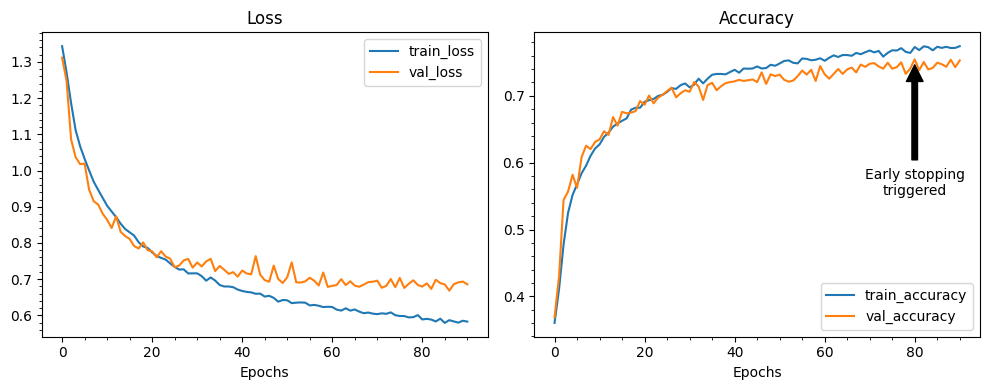

In [108]:
plot_training_curve(history_1)

In [109]:
model_1.evaluate(val_images, val_labels)

57/57 [==============================] - 1s 9ms/step - loss: 0.6796 - accuracy: 0.7545


[0.6796331405639648, 0.7544543147087097]

In [110]:
model_1.evaluate(test_images, test_labels)

63/63 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.7499


[0.6888747811317444, 0.7498747110366821]

In [111]:
predictions_1 = np.argmax(model_1.predict(test_images), axis=1)

63/63 [==============================] - 1s 5ms/step


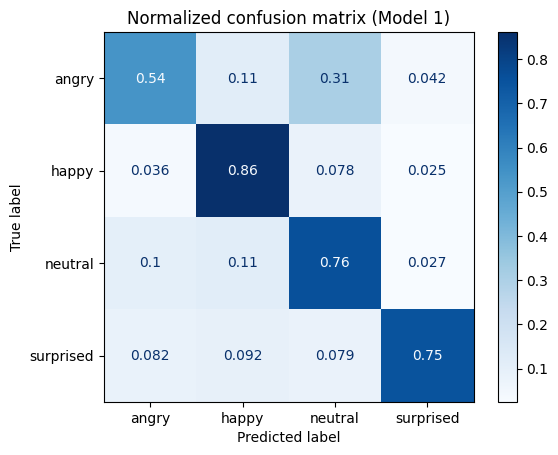

In [112]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions_1,
    display_labels=label_mapping.values(),
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix (Model 1)')
plt.show()

### Model 2 (Data augmentation configuration - 2)

In [113]:
%%time
keras.backend.clear_session()

model_2 = build_model(augment_config_2)

history_2 = model_2.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=VERBOSE)

CPU times: user 1min 32s, sys: 4.76 s, total: 1min 37s
Wall time: 1min 56s


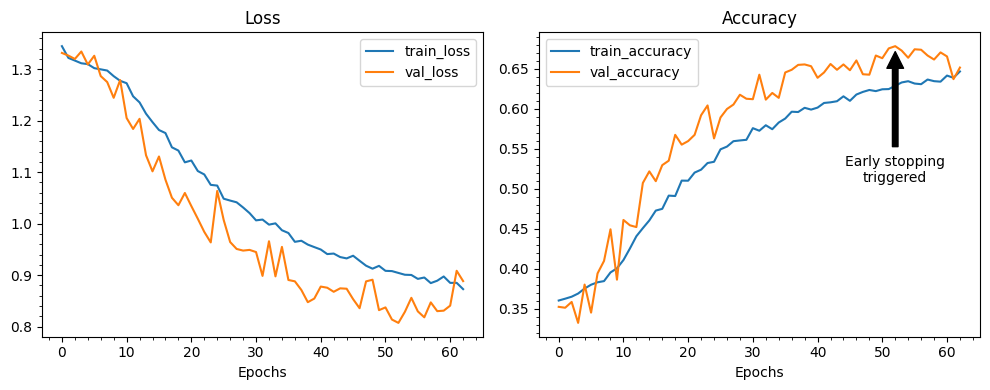

In [114]:
plot_training_curve(history_2)

In [115]:
model_2.evaluate(val_images, val_labels)

57/57 [==============================] - 0s 4ms/step - loss: 0.8072 - accuracy: 0.6782


[0.8071913719177246, 0.6781737208366394]

In [116]:
model_2.evaluate(test_images, test_labels)

63/63 [==============================] - 0s 4ms/step - loss: 0.7943 - accuracy: 0.6792


[0.7942925095558167, 0.6791979670524597]

In [117]:
predictions_2 = np.argmax(model_2.predict(test_images), axis=1)

63/63 [==============================] - 0s 3ms/step


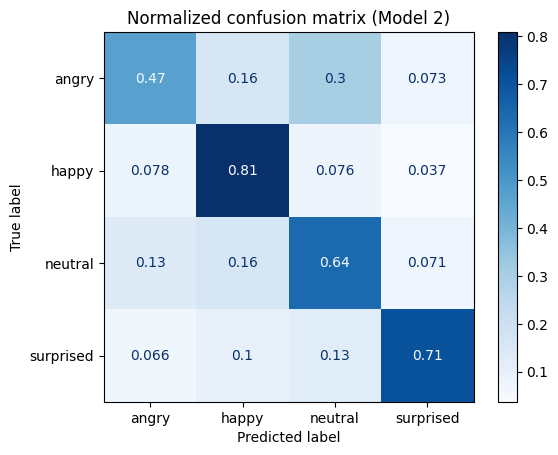

In [118]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions_2,
    display_labels=label_mapping.values(),
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix (Model 2)')
plt.show()

### Model 3 (Data augmentation configuration - 3)

In [119]:
%%time
keras.backend.clear_session()

model_3 = build_model(augment_config_3)

history_3 = model_3.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=VERBOSE)

CPU times: user 2h 22min 35s, sys: 18min 23s, total: 2h 40min 59s
Wall time: 1h 45min 56s


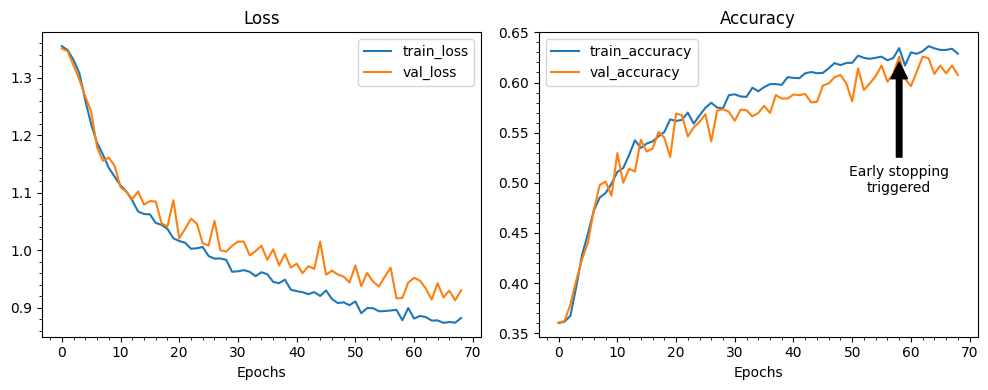

In [120]:
plot_training_curve(history_3)

In [121]:
model_3.evaluate(val_images, val_labels)

57/57 [==============================] - 9s 151ms/step - loss: 0.9387 - accuracy: 0.6047


[0.938670814037323, 0.6046770811080933]

In [122]:
model_3.evaluate(test_images, test_labels)

63/63 [==============================] - 11s 175ms/step - loss: 0.9424 - accuracy: 0.6015


[0.9424149394035339, 0.6015037298202515]

In [123]:
predictions_3 = np.argmax(model_3.predict(test_images), axis=1)

63/63 [==============================] - 15s 175ms/step


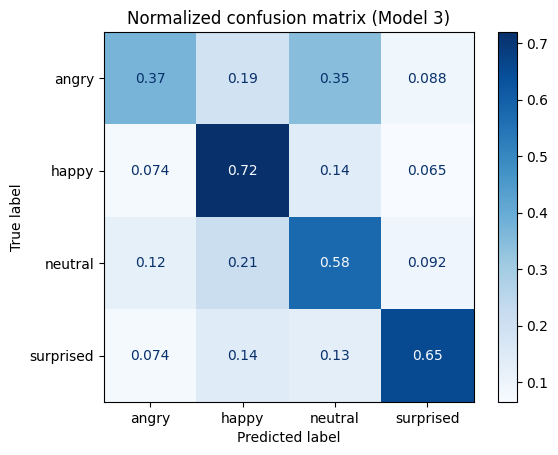

In [124]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions_3,
    display_labels=label_mapping.values(),
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix (Model 3)')
plt.show()